<img src='https://images.squarespace-cdn.com/content/v1/563a5fb2e4b0710808c31f27/1539906350737-S57ZIO18I8A3HONBY23I/Вечерняя+панорама+Нью-Йорка.jpg'>

<h2><b>New York City buildings clustering</b></h2>

PLUTO is a master record of the locations and characteristics of buildings in New York City. It’s published by the New York City Department of City Planning on an approximately quarterly-to-half-yearly basis, and is one of the more important datasets for civic analysis in New York City.

PLUTO includes information on building height, square footage, location, type, landmark status, number of units, owner, year of construction, and other related fields.

The goal of this notebook is to define neighborhoods by clustering similar buildings within them.

Performed by <b>Danila Pechenev, 21.Б15-мм group</b>

## Environment setup

### Import libraries

In [44]:
import pandas as pd
import os
import warnings
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import Counter
from IPython.display import clear_output
from typing import Tuple, Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, rand_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, ClusterMixin

import matplotlib.pyplot as plt
%matplotlib inline

### Configure libraries

In [6]:
warnings.filterwarnings('ignore')

### Unzip dataset

Dataset: https://www.kaggle.com/datasets/new-york-city/nyc-buildings?select=MN.csv

In [7]:
!unzip dataset.zip -d dataset
DATASET_PATH="dataset/"

Archive:  dataset.zip
  inflating: dataset/BK.csv          
  inflating: dataset/BX.csv          
  inflating: dataset/MN.csv          
  inflating: dataset/PLUTODD16v2.pdf  
  inflating: dataset/PlutoReadme16v2.pdf  
  inflating: dataset/Plutolay16v2.pdf  
  inflating: dataset/QN.csv          
  inflating: dataset/SI.csv          


## Data exploration

In [8]:
# We will take every Nth element from the table since the data is too large otherwise 
N = 50
df = pd.concat(
    [pd.read_csv(os.path.join(DATASET_PATH, file))[::N] for file in os.listdir(DATASET_PATH) if file.endswith(".csv")],
    ignore_index=True)
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,BK,29,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,NaN,12d,NaN,302 006,30101.0,NaN,0.000000e+00,NaN,1,16V2
2,BK,34,10,302,21.0,3012.0,13.0,33.0,11201.0,E207,...,195545.0,12d,NaN,302 009,30101.0,NaN,0.000000e+00,NaN,1,16V2
3,BK,42,36,302,21.0,3015.0,13.0,33.0,11201.0,L118,...,195222.0,12d,NaN,302 008,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,BK,45,115,302,21.0,1008.0,13.0,33.0,11201.0,E205,...,195068.0,12d,NaN,302 015,30101.0,E-89,3.000450e+09,7/11/2005,1,16V2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17170 entries, 0 to 17169
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Borough        17170 non-null  object 
 1   Block          17170 non-null  int64  
 2   Lot            17170 non-null  int64  
 3   CD             17170 non-null  int64  
 4   CT2010         17087 non-null  float64
 5   CB2010         16741 non-null  float64
 6   SchoolDist     17109 non-null  float64
 7   Council        17109 non-null  float64
 8   ZipCode        17078 non-null  float64
 9   FireComp       17093 non-null  object 
 10  PolicePrct     17107 non-null  float64
 11  HealthArea     17103 non-null  float64
 12  SanitBoro      17026 non-null  float64
 13  SanitDistrict  17028 non-null  float64
 14  SanitSub       16877 non-null  object 
 15  Address        17157 non-null  object 
 16  ZoneDist1      17161 non-null  object 
 17  ZoneDist2      505 non-null    object 
 18  ZoneDi

## Data preprocessing

### NaNs

In [10]:
# Remove columns that contain more than 50% of NaNs
mask = df.isna().sum() / len(df) < 0.5
columns_left = []
for column in mask.index:
    if mask[column]:
        columns_left.append(column)
df = df[columns_left]
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,Sanborn,TaxMap,APPBBL,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,0,21,NaN,NaN,12d,302 007,30101.0,3.000010e+09,1,16V2
1,BK,29,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,0,21,NaN,NaN,12d,302 006,30101.0,0.000000e+00,1,16V2
2,BK,34,10,302,21.0,3012.0,13.0,33.0,11201.0,E207,...,0,21,989657.0,195545.0,12d,302 009,30101.0,0.000000e+00,1,16V2
3,BK,42,36,302,21.0,3015.0,13.0,33.0,11201.0,L118,...,0,21,988847.0,195222.0,12d,302 008,30101.0,0.000000e+00,1,16V2
4,BK,45,115,302,21.0,1008.0,13.0,33.0,11201.0,E205,...,0,21,986945.0,195068.0,12d,302 015,30101.0,3.000450e+09,1,16V2


In [11]:
# NaNs of XCoord, YCoord and CB2010 columns can be replaced with mean value of respective blocks
for column in ['XCoord', 'YCoord', 'CB2010']:
    df[column] = df.groupby('Block')[column].transform(lambda x: x.fillna(x.mean()))

In [12]:
# NaNs of SanitBoro column can be replaced with the most popular value
df.SanitBoro.fillna(df.SanitBoro.value_counts(), inplace=True)

In [13]:
def fill_fst_most(fst, snd):
    df[snd] = df.groupby(fst)[snd].transform(lambda x: x.fillna(x.value_counts().index[0] if len(x.value_counts()) > 0 else np.NAN))

fill_fst_most('SanitBoro', 'SanitSub')
fill_fst_most('SanitBoro', 'SanitDistrict')
fill_fst_most('Block', 'OwnerName')

In [14]:
# Remaining NaNs can be removed as it will not affect the representativeness of the dataset
df = df.dropna(how='any')

In [15]:
df.isna().sum().sum()

0

✅ There are no null values in the dataset now

In [16]:
df.reset_index(drop=True, inplace=True)

### Features preprocessing

In [17]:
df['Version'].value_counts()

16V2    16783
Name: Version, dtype: int64

In [18]:
# All values are the same so we can delete this column
df.drop(columns=['Version'], inplace=True)

In [19]:
df.dtypes[df.dtypes == 'object']

Borough       object
FireComp      object
SanitSub      object
Address       object
ZoneDist1     object
SplitZone     object
BldgClass     object
OwnerName     object
IrrLotCode    object
ZoneMap       object
Sanborn       object
dtype: object

In [20]:
bool_cols = ['SplitZone', 'IrrLotCode']
string_cols = ['Address', 'OwnerName']
cat_cols = ['Borough', 'FireComp', 'SanitSub', 'ZoneDist1', 'BldgClass', 'ZoneMap', 'Sanborn']

In [21]:
# Process binary features
for column in bool_cols:
    df[column] = df[column].apply(lambda x: x == "Y")

In [22]:
# Remove string features
df.drop(string_cols, axis=1, inplace=True)

In [23]:
# Process categorical features
cat_rules = {}
for column in cat_cols:
    cat_rules[column] = {
        'to': {c: i for i, c in enumerate(df[column].unique())},
        'from': {i: c for i, c in enumerate(df[column].unique())}
    }
    df[column] = df[column].apply(lambda x: cat_rules[column]['to'][x])

## Separate X and y, train and test

In [24]:
X, y = df.drop(['Borough'], axis=1), df['Borough']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

## PCA

In [25]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [26]:
pca = PCA(0.8)
train_X_pca = pca.fit_transform(train_X_scaled)
test_X_pca = pca.transform(test_X_scaled)

In [27]:
for i, component in enumerate(pca.components_):
    print("Component №{} is {}% of all variance".format(
        i + 1,
        round(100 * pca.explained_variance_ratio_[i], 2))
    )

Component №1 is 15.77% of all variance
Component №2 is 10.61% of all variance
Component №3 is 7.5% of all variance
Component №4 is 5.26% of all variance
Component №5 is 4.93% of all variance
Component №6 is 4.48% of all variance
Component №7 is 3.33% of all variance
Component №8 is 3.12% of all variance
Component №9 is 3.0% of all variance
Component №10 is 2.59% of all variance
Component №11 is 2.1% of all variance
Component №12 is 2.07% of all variance
Component №13 is 1.79% of all variance
Component №14 is 1.77% of all variance
Component №15 is 1.66% of all variance
Component №16 is 1.64% of all variance
Component №17 is 1.62% of all variance
Component №18 is 1.57% of all variance
Component №19 is 1.56% of all variance
Component №20 is 1.54% of all variance
Component №21 is 1.52% of all variance
Component №22 is 1.5% of all variance


### Visualization for 2 components

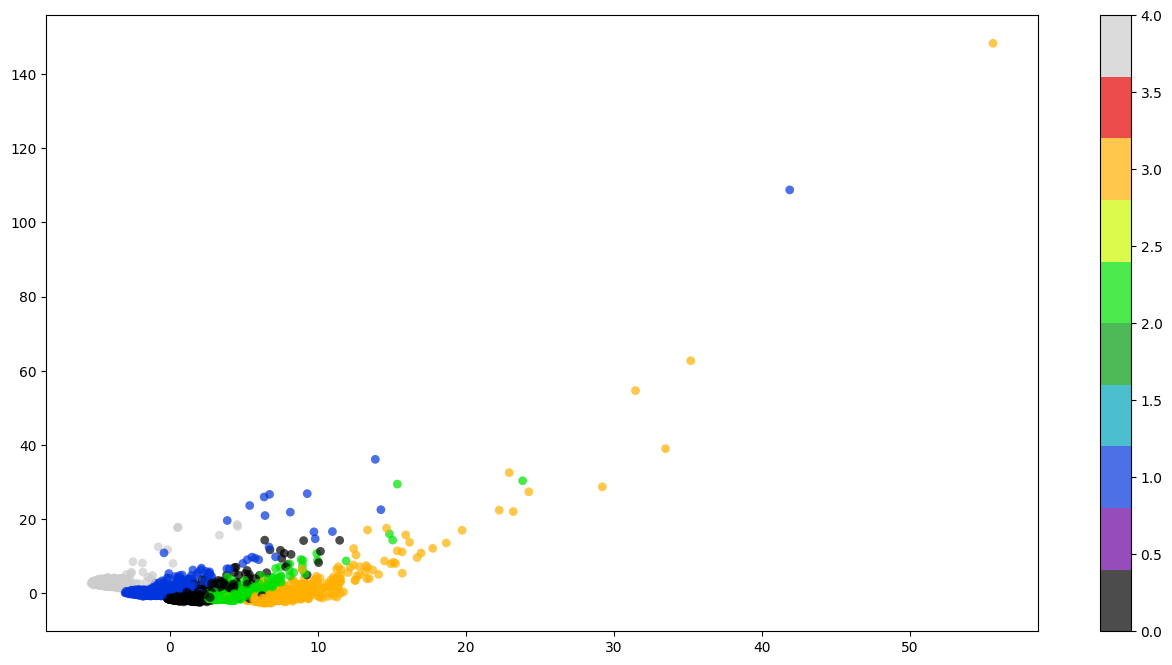

In [28]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train_X_scaled)

plt.figure(figsize=(16, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

We can see 5 groups but it's still hard to distinguish them

## TSNE

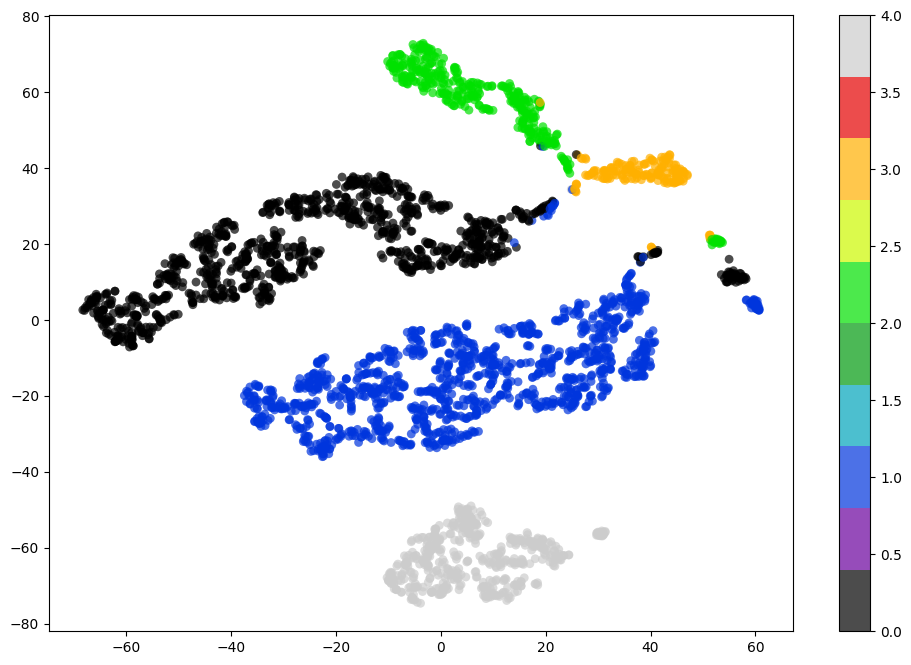

In [29]:
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(test_X_scaled)

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12, 8))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=test_y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar();

**That's much better**

However, there are points that clustered inaccurately

## Models comparison

In [30]:
# Determine metrics for comparison
results = pd.DataFrame(
    columns=['model',
             'training_time',
             'homogeneity_score',
             'completeness_score',
             'rand_score',
             'f1_score',
             'accuracy_score',
             'precision_score',
             'recall_score']
)

65 features are too much. Let's see how many of them we can discard without significant effect on the quality of the model

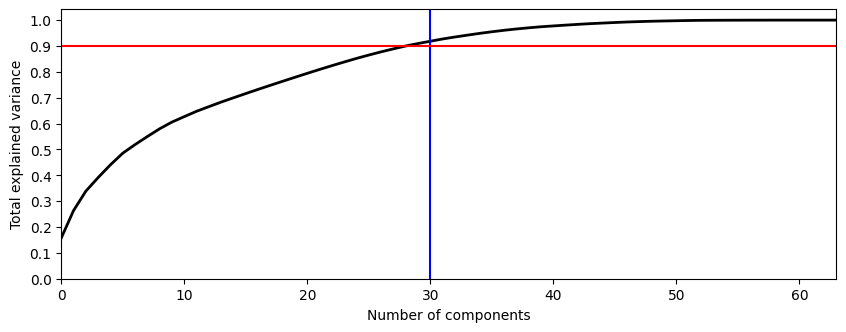

In [31]:
pca = PCA().fit(train_X_scaled)

plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.9, c='r')
plt.show();

That means that 30 features describe more than 90% of the variance. We will reduce the data to 30 features to fit models faster without significant loss of information

In [32]:
train_X_30cps = PCA(n_components=30).fit_transform(train_X)
test_X_30cps = PCA(n_components=30).fit_transform(test_X)

In [33]:
def get_valid_prediction(target, labels):
    res = pd.DataFrame()
    res['target'] = target
    res['label'] = labels

    most_commons = []
    for cluster_label in np.unique(labels):
        most_commons += list(map(lambda x: (cluster_label, *x), Counter(res[res['label'] == cluster_label]['target']).most_common(5)))

    most_commons.sort(key=lambda x: (x[2]), reverse=True)

    cluster_to_borough_map = {}
    for elem in most_commons:
        if elem[0] not in cluster_to_borough_map.keys():
            cluster_to_borough_map[elem[0]] = elem[1]

    predictions = [cluster_to_borough_map[label] for label in labels]
    res['label'] = predictions

    return res, cluster_to_borough_map, predictions

In [34]:
def estimate_model(name, model, grid: GridSearchCV, train_X, train_Y, test_X, test_Y, df, fit_predict=False):
    res = {'model': name}

    grid.fit(train_X)
    best_params = grid.best_params_

    start_time = datetime.now()
    model = model.set_params(**best_params)
    model.fit(train_X)
    end_time = datetime.now()
    res['training_time'] = end_time - start_time
    clear_output()

    _, cluster_to_borough_map, y_pred = get_valid_prediction(train_Y, model.labels_)
    if not fit_predict:
        y_pred = [cluster_to_borough_map[label] for label in model.predict(test_X)]
        test = test_Y
    else:
        test = train_Y

    res['homogeneity_score'] = homogeneity_score(test, y_pred)
    res['completeness_score'] = completeness_score(test, y_pred)
    res['rand_score'] = rand_score(test, y_pred)
    res['f1_score'] = f1_score(test, y_pred, average='weighted')
    res['accuracy_score'] = accuracy_score(test, y_pred)
    res['precision_score'] = precision_score(test, y_pred, average='weighted')
    res['recall_score'] = recall_score(test, y_pred, average='weighted')

    cm = confusion_matrix(test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return grid, model, pd.concat([df, pd.DataFrame(res, index=[0])])

### Custom KMeans

In [35]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

In [36]:
param_grid = {
    'n_clusters': [5, 10, 12, 15],
    'tol': [
        0.01, 0.001, 0.0001]
}

myKMeans = MyKMeans(random_state=0)
grid_search = GridSearchCV(myKMeans, param_grid, scoring='rand_score', cv=2, n_jobs=-1)

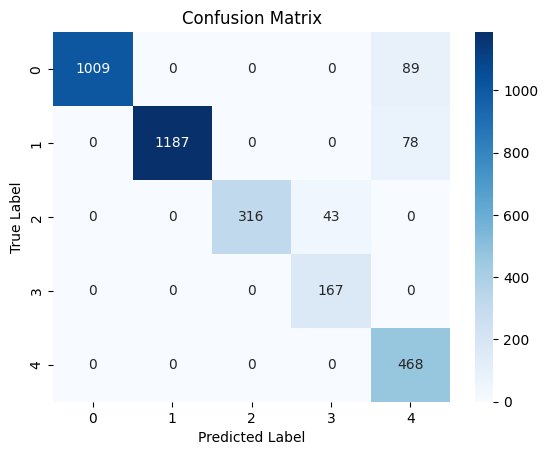

In [37]:
_, _, results = estimate_model("MyKMeans", myKMeans, grid_search, train_X_30cps, train_y, test_X_30cps, test_y, results)

In [38]:
results

,model,training_time,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score
0,MyKMeans,0 days 00:00:00.210065,0.874621,0.848267,0.948828,0.940603,0.937444,0.95315,0.937444


### Sklearn KMeans

In [39]:
param_grid = {
    'n_clusters': [10, 12, 15],
    'init': ['random', 'k-means++'],  
    'max_iter': [100, 200]
}

kmeans = KMeans()
grid_search = GridSearchCV(
    kmeans,
    param_grid,
    scoring='rand_score',
    cv=5,
    n_jobs=-1
)

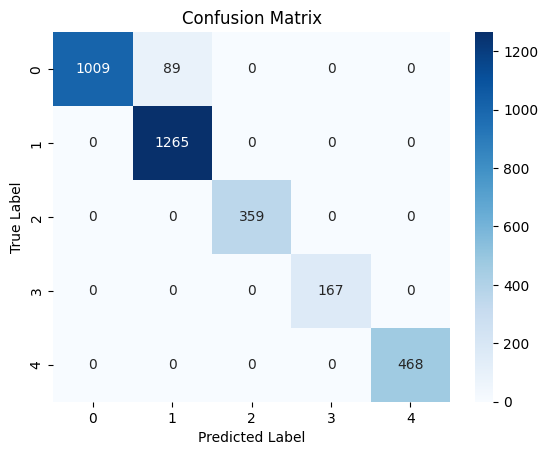

In [40]:
_, _, results = estimate_model("SklearnKMeans", kmeans, grid_search, train_X_30cps, train_y, test_X_30cps, test_y, results)

In [41]:
results

,model,training_time,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score
0,MyKMeans,0 days 00:00:00.210065,0.874621,0.848267,0.948828,0.940603,0.937444,0.953150,0.937444
0,SklearnKMeans,0 days 00:00:00.148486,0.929966,0.933825,0.964072,0.973379,0.973488,0.975231,0.973488


### Sklearn DBSCAN

In [45]:
param_grid = {
    'eps': [1, 0.5, 2],
    'min_samples': [1], 
    'algorithm': ['kd_tree', 'auto'],
    'leaf_size': [30, 50], 
    'metric': ['euclidean'],
    'p': [None],
}

dbscan = DBSCAN()
grid_search = GridSearchCV(dbscan, param_grid, scoring='rand_score', cv=5, n_jobs=-1)

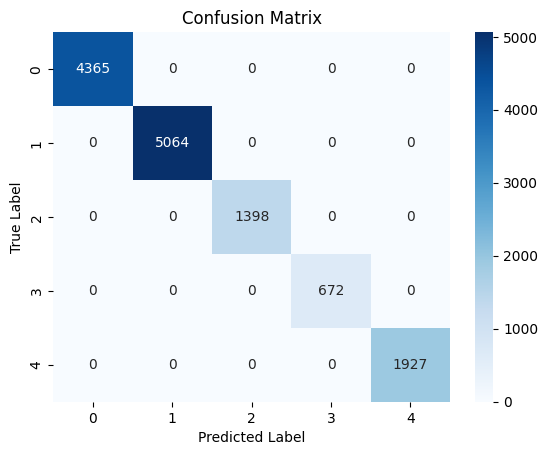

In [46]:
_, _, results = estimate_model('DBSCAN', dbscan, grid_search, train_X_30cps, train_y, test_X_30cps, test_y, results, fit_predict=True)

In [47]:
results

,model,training_time,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score
0,MyKMeans,0 days 00:00:00.210065,0.874621,0.848267,0.948828,0.940603,0.937444,0.953150,0.937444
0,SklearnKMeans,0 days 00:00:00.148486,0.929966,0.933825,0.964072,0.973379,0.973488,0.975231,0.973488
0,DBSCAN,0 days 00:00:00.262621,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Results

* DBSCAN has the best quality and separate clusters perfectly

* DBSCAN is slowest to train

* Sklean KMeans is the fastest to train

* My KMeans implementation has the worst score